### Experimental validation by coarse-graining of the global EPR for 30V data 

In [ ]:
# download experimental data files
# import requests

# urls = [
#     "https://huggingface.co/datasets/MLDS-NUS/Experimental_Images/resolve/main/30V_Jan24.pkl",
#     # "https://huggingface.co/datasets/MLDS-NUS/Experimental_Images/resolve/main/60V_Dec24.pkl",  
# ]

# for url in urls:
#     filename = url.split("/")[-1]
#     with open(filename, "wb") as f:
#         f.write(requests.get(url).content)


In [7]:
import pickle

# load train_data.pkl
with open("30V_Jan24.pkl", "rb") as f:
    data_30 = pickle.load(f)
 


In [8]:
if isinstance(data_30, dict):
    print(data_30.keys())
print(len(data_30)) 

dict_keys(['30V_Tra_0', '30V_Tra_1', '30V_Tra_2', '30V_Tra_3', '30V_Tra_4', '30V_Tra_5', '30V_Tra_6', '30V_Tra_7', '30V_Tra_8', '30V_Tra_9', '30V_Tra_10', '30V_Tra_11', '30V_Tra_12', '30V_Tra_13', '30V_Tra_14', '30V_Tra_15', '30V_Tra_16', '30V_Tra_17', '30V_Tra_18', '30V_Tra_19', '30V_Tra_20', '30V_Tra_21', '30V_Tra_22', '30V_Tra_23', '30V_Tra_24', '30V_Tra_25', '30V_Tra_26', '30V_Tra_27', '30V_Tra_28', '30V_Tra_29', '30V_Tra_30', '30V_Tra_31', '30V_Tra_32', '30V_Tra_33', '30V_Tra_34', '30V_Tra_35', '30V_Tra_36', '30V_Tra_37', '30V_Tra_38', '30V_Tra_39', '30V_Tra_40', '30V_Tra_41', '30V_Tra_42', '30V_Tra_43', '30V_Tra_44', '30V_Tra_45', '30V_Tra_46', '30V_Tra_47', '30V_Tra_48', '30V_Tra_49', '30V_Tra_50', '30V_Tra_51', '30V_Tra_52', '30V_Tra_53', '30V_Tra_54', '30V_Tra_55', '30V_Tra_56', '30V_Tra_57', '30V_Tra_58', '30V_Tra_59', '30V_Tra_60', '30V_Tra_61', '30V_Tra_62', '30V_Tra_63', '30V_Tra_64', '30V_Tra_65', '30V_Tra_66', '30V_Tra_67', '30V_Tra_68', '30V_Tra_69', '30V_Tra_70', '30V_

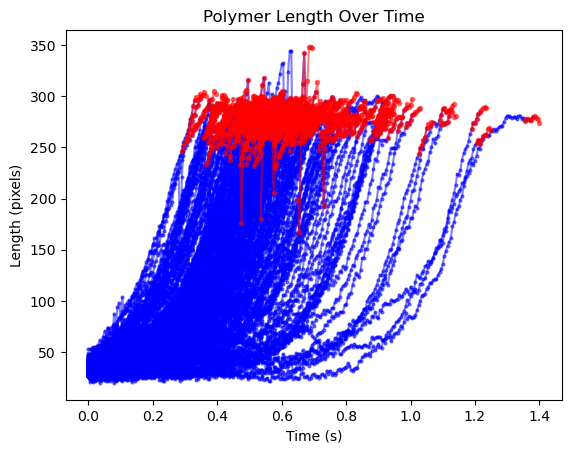

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def find_leftmost_nonzero(image):
    """
    Find the position of the leftmost non-zero element in a binary image
    :param image: 2D numpy array, binary image
    :return: Column index of the leftmost non-zero element, returns -1 if no non-zero element is found
    """
    # Check if each column has any non-zero elements
    nonzero_columns = np.any(image != 0, axis=0)
    
    # Find the index of the first non-zero element
    nonzero_indices = np.where(nonzero_columns)[0]
    
    # Return -1 if no non-zero elements are found
    if len(nonzero_indices) == 0:
        return -1
    
    return nonzero_indices[0]

def find_rightmost_nonzero(image):
    """
    Find the position of the rightmost non-zero element in a binary image
    :param image: 2D numpy array, binary image
    :return: Column index of the rightmost non-zero element, returns -1 if no non-zero element is found
    """
    # Check if each column has any non-zero elements
    nonzero_columns = np.any(image != 0, axis=0)
    
    # Find the index of the last non-zero element
    nonzero_indices = np.where(nonzero_columns)[0]
    
    # Return -1 if no non-zero elements are found
    if len(nonzero_indices) == 0:
        return -1
    
    return nonzero_indices[-1]

def Img2length(data):
    """
    Calculate the length of lines in a set of images (rightmost non-zero column index - leftmost non-zero column index)
    :param data: 3D numpy array, shape (num_images, height, width)
    :return: numpy array containing the line lengths for each image
    """
    lengths = []
    rightmost, leftmost=[],[]
    for img in data:
        leftmost_index = find_leftmost_nonzero(img-255)
        rightmost_index = find_rightmost_nonzero(img-255)
        
        # Calculate length if valid boundaries are found, otherwise set to 0
        if leftmost_index != -1 and rightmost_index != -1 and rightmost_index >= leftmost_index:
            lengths.append(rightmost_index - leftmost_index)
        else:
            lengths.append(0)
        rightmost.append(rightmost_index)
        leftmost.append(leftmost_index)
    return np.array(lengths), np.array(rightmost), np.array(leftmost)


for i in range(len(data_30)):
    length, rightmost, leftmost= Img2length(data_30["30V_Tra_"+str(i)])
    t=np.arange(len(length))*0.005
    plt.plot(t[:-4],length[:-4],'bo-', markersize=2, zorder=1, alpha=0.5)
    plt.plot(t[-10:], length[-10:], 'ro-',markersize=3, zorder=2, alpha=0.5)

    plt.xlabel('Time (s)')
    plt.ylabel('Length (pixels)')
    plt.title('Polymer Length Over Time')

In [10]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def discretize_trajectory(trajectory, bin_edges):
    """
    Discretize continuous trajectory into a multidimensional grid
    
    Parameters:
        trajectory: (N, dim) array, dim-dimensional trajectory
        bin_edges: list of bin boundaries for each dimension
        
    Returns:
        bin_indices: (N, dim) array, indices of each point in the multidimensional grid
    """
    dim = trajectory.shape[1]
    n_bins = [len(edges) - 1 for edges in bin_edges]
    bin_indices = np.zeros_like(trajectory, dtype=int)
    
    for d in range(dim):
        # Assign points to bins
        bin_indices[:, d] = np.digitize(trajectory[:, d], bin_edges[d]) - 1
        # Ensure indices are within [0, n_bins[d]-1]
        bin_indices[:, d] = np.clip(bin_indices[:, d], 0, n_bins[d] - 1)
    
    return bin_indices

def determine_global_bins(trajectories, n_bins=10):
    """
    Determine global bin boundaries based on all trajectories
    
    Parameters:
        trajectories: list of trajectories, each is a (N_i, dim) array
        n_bins: number of bins for each dimension
        
    Returns:
        global_bin_edges: list of global bin boundaries
    """
    # Collect all trajectory points
    all_points = np.vstack(trajectories)
    dim = all_points.shape[1]
    
    min_vals = np.min(all_points, axis=0)
    max_vals = np.max(all_points, axis=0)
    
    bin_edges = []
    for d in range(dim):
        # Create bin boundaries, slightly expand range to avoid boundary issues
        range_expansion = 0.05 * (max_vals[d] - min_vals[d])
        min_val = min_vals[d] - range_expansion
        max_val = max_vals[d] + range_expansion
        
        edges = np.linspace(min_val, max_val, n_bins + 1)
        bin_edges.append(edges)
    
    return bin_edges

def count_transitions(trajectories, bin_edges):
    """
    Count transitions for all trajectories
    
    Parameters:
        trajectories: list of trajectories
        bin_edges: global bin boundaries
        
    Returns:
        forward_counts_dict: forward transition counts dictionary {(start_index_tuple): {end_index_tuple: count}}
        reverse_counts_dict: reverse transition counts dictionary {(start_index_tuple): {end_index_tuple: count}}
        total_transitions: total number of transitions
    """
    dim = len(bin_edges)
    forward_counts = {}
    reverse_counts = {}
    total_transitions = 0
    
    # Iterate through all trajectories
    for traj_idx, trajectory in enumerate(tqdm(trajectories, desc="Processing trajectories")):
        # Discretize current trajectory
        bin_indices = discretize_trajectory(trajectory, bin_edges)
        n_points = bin_indices.shape[0]
        
        # Count transitions for current trajectory
        for k in range(n_points - 1):
            # Get index tuples for current and next states
            start_idx = tuple(bin_indices[k])
            end_idx = tuple(bin_indices[k+1])
            
            # Forward transition counts
            if start_idx not in forward_counts:
                forward_counts[start_idx] = {}
            if end_idx not in forward_counts[start_idx]:
                forward_counts[start_idx][end_idx] = 0
            forward_counts[start_idx][end_idx] += 1
            
            # Reverse transition counts (time reversal)
            if end_idx not in reverse_counts:
                reverse_counts[end_idx] = {}
            if start_idx not in reverse_counts[end_idx]:
                reverse_counts[end_idx][start_idx] = 0
            reverse_counts[end_idx][start_idx] += 1
            
            total_transitions += 1
    
    return forward_counts, reverse_counts, total_transitions

def calculate_transition_probabilities(counts_dict):
    """
    Calculate transition probabilities
    
    Parameters:
        counts_dict: transition counts dictionary
        
    Returns:
        probs_dict: transition probabilities dictionary {(start_idx): {end_idx: probability}}
    """
    probs_dict = {}
    
    for start_idx, end_counts in counts_dict.items():
        total = sum(end_counts.values())
        probs_dict[start_idx] = {}
        
        for end_idx, count in end_counts.items():
            probs_dict[start_idx][end_idx] = count / total
    
    return probs_dict

def estimate_epr_with_counting(trajectories, dt, n_bins=8, max_irreversible=10.0):
    """
    Estimate entropy production rate using histogram counting method (general dimension version)
    
    Parameters:
        trajectories: list of trajectories, each is a (N_i, dim) array
        dt: time step
        n_bins: number of bins for each dimension
        max_irreversible: maximum KL contribution for completely irreversible transitions
        
    Returns:
        ep_rate: estimated entropy production rate
        kl_contributions: list of KL contributions for all transitions (for diagnostics)
    """
    # 0. Get system dimension
    dim = trajectories[0].shape[1]
    print(f"System dimension: {dim}D, using {n_bins} bins per dimension")
    
    # 1. Determine global bin boundaries
    bin_edges = determine_global_bins(trajectories, n_bins)
    print(f"Bin boundaries determined") 
    
    # 2. Count transitions for all trajectories
    forward_counts, reverse_counts, total_transitions = count_transitions(trajectories, bin_edges)
    print(f"Total transitions: {total_transitions}")
    print(total_transitions)
    
    # 3. Calculate forward transition probabilities
    forward_probs = calculate_transition_probabilities(forward_counts)

    # 4. Calculate reverse transition probabilities
    reverse_probs = calculate_transition_probabilities(reverse_counts)
    
    # 5. Calculate relative entropy contribution for each transition
    kl_contributions = []
    valid_transitions = 0
    irreversible_transitions = 0
    
    # Get minimum reverse probability
    min_val = min(
        prob
        for inner in reverse_probs.values()
        for prob in inner.values()
        if prob > 0
    )
    print('min', min_val)
    for start_idx, end_dict in tqdm(forward_counts.items(), desc="Calculating KL divergence"):
        for end_idx, count in end_dict.items():
            # Get forward probability
            p_forward = forward_probs[start_idx][end_idx]
            
            # Get reverse probability - note direction reversal
            p_reverse = 0.0 
            if end_idx in reverse_probs.get(start_idx, {}):
                p_reverse = reverse_probs[start_idx][end_idx] 
            
            # Calculate KL contribution
            if p_reverse > 0:
                log_ratio = np.log(p_forward / p_reverse)
            else:
                # Completely irreversible transition
                log_ratio = np.log(p_forward /min_val* max_irreversible)
                irreversible_transitions += count
            
            # Accumulate contributions for each occurrence of this transition
            kl_contributions.extend([log_ratio] * count)
            valid_transitions += count
    
    # 6. Calculate average relative entropy
    if valid_transitions > 0:
        H = np.mean(kl_contributions)
    else:
        H = 0.0
        print("Warning: No valid transitions found!")
    
    # 7. Calculate entropy production rate
    ep_rate = H / dt
    
    print(f"Valid transitions: {valid_transitions}/{total_transitions} ({100*valid_transitions/total_transitions:.1f}%)")
    print(f"Completely irreversible transitions: {irreversible_transitions} ({100*irreversible_transitions/total_transitions:.1f}%)")
    print(f"Average relative entropy H: {H:.6f}")
    print(f"Estimated entropy production rate: {ep_rate:.4f}")
    
    return ep_rate, kl_contributions

System dimension: 2D, using 100 bins per dimension
Bin boundaries determined


Processing trajectories: 100%|██████████| 220/220 [00:00<00:00, 16709.77it/s]


Total transitions: 1980
1980
min 0.07692307692307693


Calculating KL divergence: 100%|██████████| 819/819 [00:00<00:00, 334189.61it/s]

Valid transitions: 1980/1980 (100.0%)
Completely irreversible transitions: 1814 (91.6%)
Average relative entropy H: 3.449304
Estimated entropy production rate: 68.9861


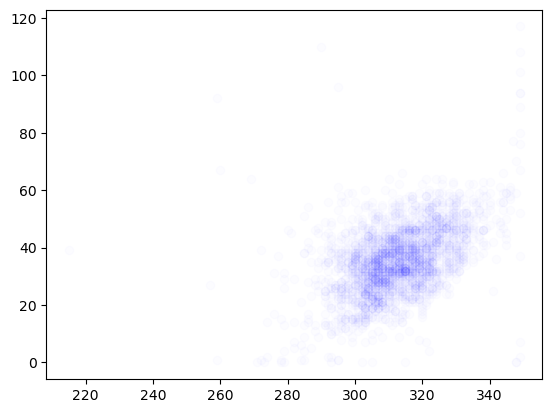

In [11]:
traj_60=[]
for key in data_30.keys():
    length, rightmost, leftmost= Img2length(data_30[key])
    traj_60.append((np.vstack((rightmost, leftmost)).T)[-10:])

ep_rate, kl_contributions = estimate_epr_with_counting(
        trajectories=traj_60,
        dt=0.05,
        n_bins=100
    )

i=1
for i in range(len(data_30)):
    plt.scatter(traj_60[i][:,0],traj_60[i][:,1], alpha=0.01, c='b')